In [16]:
import mne 
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from src.preprocessing_lib import EcogReader, prepare_condition_ts, parcellation_to_indices
from mne.time_frequency import psd_array_multitaper, psd_array_welch, csd_array_multitaper

In [13]:
# Make condition specific time series (epoched)
subject = 'DiAs'
stage= 'preprocessed'
matlab = False
decim = 2
conditions = ['Rest', 'Face', 'Place']
sfreq = 500/decim
data_path = Path('~','projects', 'cifar', 'data').expanduser()

ts = prepare_condition_ts(data_path, subject=subject, stage=stage, matlab = matlab,
                     preprocessed_suffix=preprocessed_suffix, decim=decim)

Opening raw data file /home/guime/projects/cifar/data/derivatives/DiAs/ieeg/DiAs_hfb_continuous_raw.fif...
    Range : 0 ... 348212 =      0.000 ...   696.424 secs
Ready.
Reading 0 ... 348212  =      0.000 ...   696.424 secs...
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Loading data for 200 events and 1126 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Used Annotations descriptions: ['-1', '-2', 'Face010', 'Face020', 'Face030', 'Face040', 'Face050', 'Face060', 'Face070', 'Face110', 'Face120', 'Face130', 'Face140', 'Face150', 'Face160', 'Face170', 'Place010', 'Place020', 'Place030', 'Place040', 'Place050', 'Place060', 'Place070', 'Place110', 'Place120', 'Place130', 'Place140', 'Place150', 'Place160', 'Place170', 'boundary']
Not setting metadata
Not setting m

/home/guime/projects/cifar/src/preprocessing_lib.py:907: RuntimeWarning: The measurement information indicates a low-pass frequency of 250 Hz. The decim=2 parameter will result in a sampling frequency of 250 Hz, which can cause aliasing artifacts.
  epoch = epoch.copy().decimate(decim)
/home/guime/projects/cifar/src/preprocessing_lib.py:907: RuntimeWarning: The measurement information indicates a low-pass frequency of 250 Hz. The decim=2 parameter will result in a sampling frequency of 250 Hz, which can cause aliasing artifacts.
  epoch = epoch.copy().decimate(decim)
/home/guime/projects/cifar/src/preprocessing_lib.py:907: RuntimeWarning: The measurement information indicates a low-pass frequency of 250 Hz. The decim=2 parameter will result in a sampling frequency of 250 Hz, which can cause aliasing artifacts.
  epoch = epoch.copy().decimate(decim)
/home/guime/projects/cifar/src/preprocessing_lib.py:898: RuntimeWarning: The measurement information indicates a low-pass frequency of 250 

In [21]:
# Get indices associated with functional group
reader = EcogReader(data_path, subject=subject)
df_visual = reader.read_channels_info(fname='visual_channels.csv')
indices = parcellation_to_indices(df_visual, parcellation='group', matlab=False)
group = list(indices.keys())

['O', 'F', 'R']

In [54]:
x.shape

(56, 10, 501)

    Using multitaper spectrum estimation with 19 DPSS windows
    Using multitaper spectrum estimation with 19 DPSS windows
    Using multitaper spectrum estimation with 19 DPSS windows


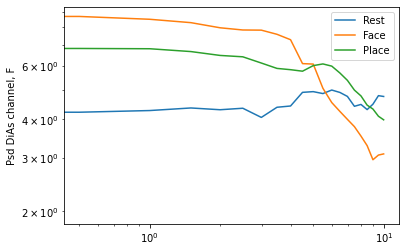

In [86]:
# Average over functional groups Multitaper
g = 'F'
idx = indices[g]
for c in conditions:
    x = ts[c]
    (n,m,N) = x.shape
    x = np.transpose(x, (2,0,1))
    psds, freqs = psd_array_multitaper(x, sfreq = sfreq, fmax=10, bandwidth=10)
    s = psds[0]
    sg = np.mean(s[idx,:],0)
    plt.plot(freqs, sg, label=c)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.ylabel(f'Psd {subject} channel, {g}')

Effective window size : 0.800 (s)
Effective window size : 0.800 (s)
Effective window size : 0.800 (s)


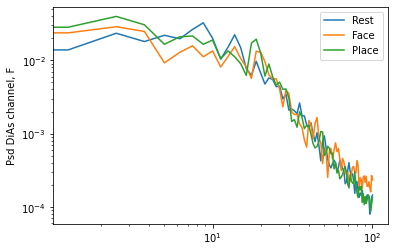

In [85]:
# Average over functional groups Welch method
g = 'F'
idx = indices[g]
for c in conditions:
    x = ts[c]
    (n,m,N) = x.shape
    x = np.transpose(x, (2,0,1))
    psds, freqs = psd_array_welch(x, sfreq, fmin=0, fmax=100, n_fft=200, n_overlap=50)
    s = psds[0]
    sg = np.mean(s[idx,:],0)
    plt.plot(freqs, sg, label=c)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.ylabel(f'Psd {subject} channel, {g}')


In [ ]:
def ts_to_psd(ts, indices, condition='Face', sfreq = 250, fmax=100, bandwidth=6, 
              group='F'):
    """"
    Compute spectral density from condition specific time series
    """"
    # Take condition specific time series
    x = ts[condition]
    # Reshapre time series in suitable MNE format
    (n,m,N) = x.shape
    x = np.transpose(x, (2,0,1))
    # Compute spectral density with multitaper method
    psds, freqs = psd_array_multitaper(x, sfreq = sfreq, fmax=100, bandwidth=6)
    # Average over functional group 
    idx = indices[group]
    # Return condition specifc psd
    s = psds[0]
    # Average over functional group
    s = np.mean(s[idx,:],0)
    return s, freqs

In [87]:
from src.preprocessing_lib import EcogReader


In [97]:
# Read continuous HFA
path = Path('~','projects', 'cifar', 'data').expanduser()
preprocessed_suffix = '_hfb_continuous_raw.fif' 
stage = 'preprocessed'
visual_chan = df_visual['chan_name'].to_list()
reader = EcogReader(path, subject=subject, stage=stage,
                     preprocessed_suffix=preprocessed_suffix,
                     epoch=epoch)
hfb = reader.read_ecog()
hfb.pick(visual_chan)

Opening raw data file /home/guime/projects/cifar/data/derivatives/DiAs/ieeg/DiAs_hfb_continuous_raw.fif...
    Range : 0 ... 348212 =      0.000 ...   696.424 secs
Ready.
Reading 0 ... 348212  =      0.000 ...   696.424 secs...


<Raw | DiAs_hfb_continuous_raw.fif, 10 x 348213 (696.4 s), ~26.6 MB, data loaded>

Channels marked as bad: none


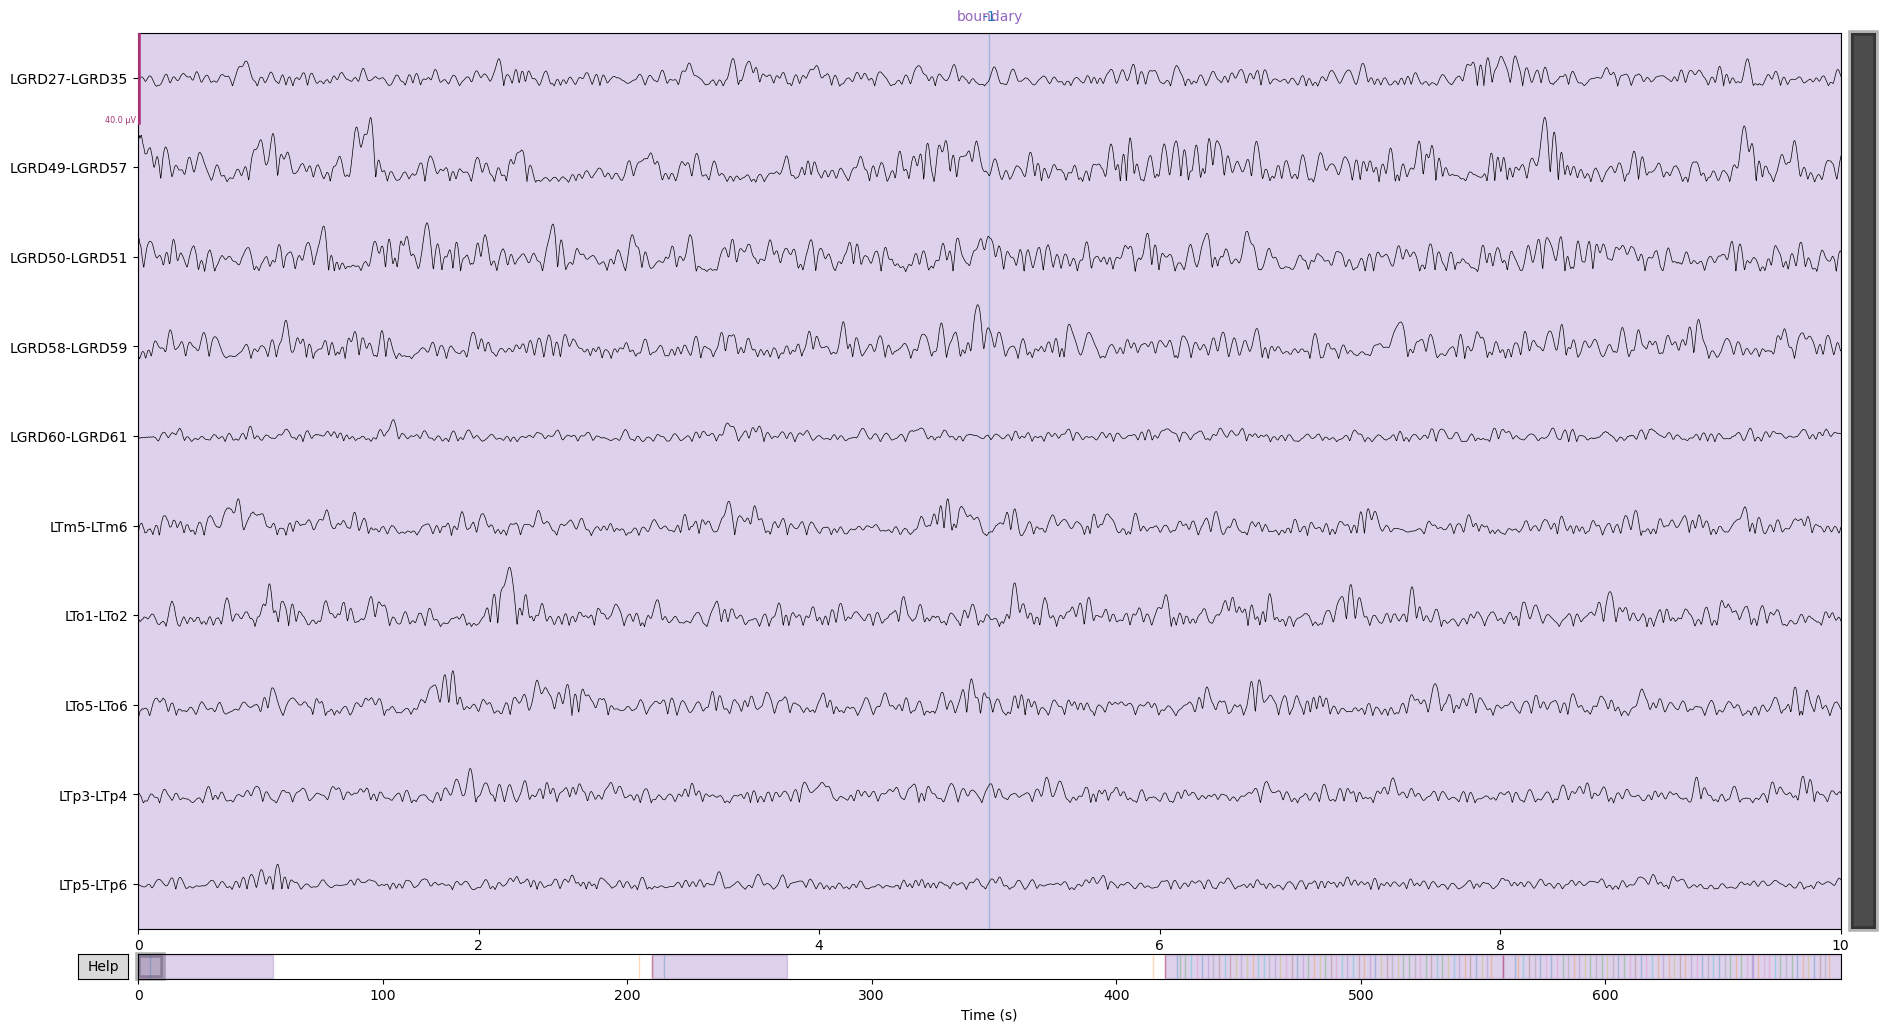

Channels marked as bad: none


In [98]:
%matplotlib qt
hfb.plot()

In [99]:
hfa_rest = hfb.copy().crop(tmin=150, tmax=350)
hfa_stim = hfb.copy().crop(tmin=450, tmax=650)

In [131]:
# Epoch rest and stim HFA
duration = 5
epochs_rest = mne.make_fixed_length_epochs(hfa_rest, duration=duration,overlap=0)
epochs_stim = mne.make_fixed_length_epochs(hfa_stim, duration=duration, overlap=0)

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated


Number of events,40
Events,1: 40
Time range,0.000 – 4.998 sec
Baseline,off


Loading data for 40 events and 2500 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 2 DPSS windows


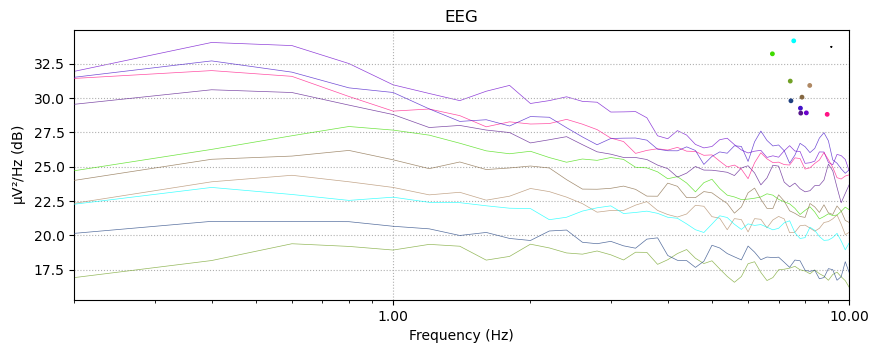

In [132]:
epochs_rest.plot_psd(fmin=0.1, fmax=10, bandwidth=0.5, xscale='log')

Loading data for 40 events and 2500 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 2 DPSS windows


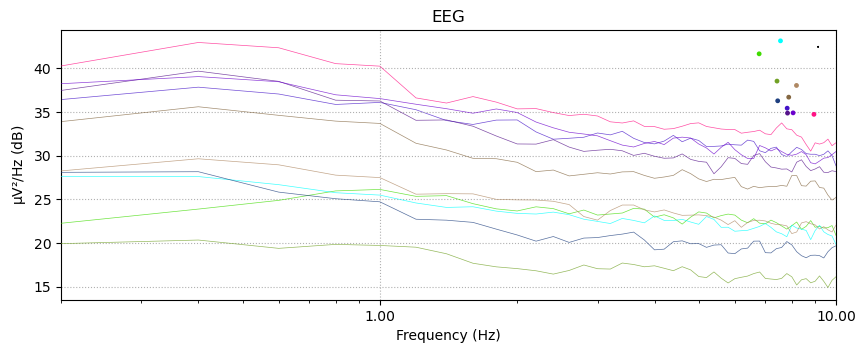

In [133]:
epochs_stim.plot_psd(fmin=0.1, fmax=10, bandwidth=0.5, xscale='log')

In [102]:
from mne.time_frequency import psd_multitaper

In [104]:
psd_multitaper(epochs_rest)

Loading data for 40 events and 2500 original time points ...
1 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


(array([[[1.44268436e-10, 3.46829629e-10, 3.37954752e-10, ...,
          2.17275317e-16, 1.47564785e-16, 6.63003574e-17],
         [1.04183936e-09, 1.57704839e-09, 1.20444786e-09, ...,
          5.20954706e-16, 5.47528290e-16, 2.38896094e-16],
         [5.27393101e-10, 1.19687656e-09, 9.92459052e-10, ...,
          2.02766321e-15, 1.96535188e-15, 7.55251944e-16],
         ...,
         [1.50148762e-10, 2.75661483e-10, 2.66848707e-10, ...,
          2.44647292e-15, 1.40852104e-15, 1.17600031e-15],
         [6.62696921e-11, 1.54629656e-10, 1.56811013e-10, ...,
          7.52390584e-17, 7.32397625e-17, 5.44992841e-17],
         [2.00136947e-11, 3.64571259e-11, 4.23538083e-11, ...,
          3.51431923e-17, 7.85698687e-18, 3.10475540e-18]],
 
        [[6.33132802e-11, 1.29839006e-10, 1.14941946e-10, ...,
          1.91362589e-16, 1.53767809e-16, 1.05392465e-16],
         [1.76011649e-09, 3.29424531e-09, 2.85232809e-09, ...,
          1.49421209e-15, 1.04599485e-15, 3.52042894e-16],
       

Observations: Taking longer time segments enable us to see more of resolution on the low frequency behavior of the HFA. But it is hard to see more detailed difference apart from the obvious face that power is higher during stimuli than during rest for visually responsive channels. I think this suggests that psd analysis is not so interesting to add to the result section. A psd analysis of GC is still interesting though as it enables us to check that power is concentrated in lower frequencies. The main points are that in each conditions and for each group:
* Power spectral density is concentrated in low frequencies of the HFA (less than 40Hz)
* Spectral GC is also concentrated in low frequencies
In fact the concentration of spectral GC in the low frequencies is the main interest here.
